In [1]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *
from multioutput_rbf_linear_gp import *


import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
import os
import torch
import gpytorch
import datetime
import seaborn as sns


# sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Data

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:01<00:00, 2227.62it/s]



===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59
Number of vessel groups: 9


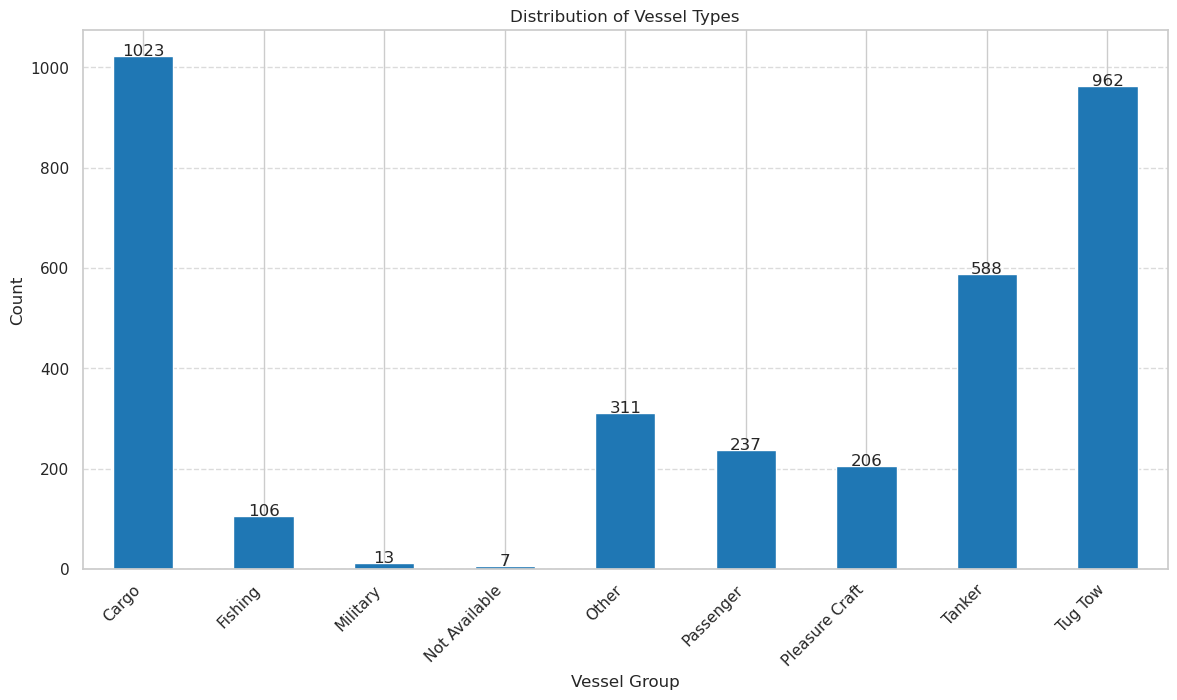

In [3]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# Display vessel group histogram
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

# Print group to ID mapping for reference

# print("\nVessel Group to ID mapping:")
# for group, group_id in gp_regression_dataset.vessel_group_to_id.items():
#     print(f"  {group}: {group_id}")

## Fit GP Models

In [ ]:
# # Control flag - set to True to load existing models if available, False to force retraining
# reload_existing_models = True

# # num_trajectories = len(gp_regression_dataset)
# num_trajectories = 1000  # For testing, set to 1 to avoid long training times
# models = {}
# likelihoods = {}
# losses = {}

# # Create a filename based on the dataset's date range and number of trajectories
# start_date = date_range[0].strftime('%Y-%m-%d')
# end_date = date_range[-1].strftime('%Y-%m-%d')

# # If it's a single day, use just one date, otherwise show the range
# if start_date == end_date:
#     date_identifier = start_date
# else:
#     date_identifier = f"{start_date}_to_{end_date}"

# # Define model file path with number of trajectories included
# save_dir = "models"
# os.makedirs(save_dir, exist_ok=True)
# save_path = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n{num_trajectories}.pt"

# # Check if models with current num_trajectories already exist
# if os.path.exists(save_path) and reload_existing_models:
#     print(f"Found existing model bundle for date range {date_identifier} with {num_trajectories} trajectories")
#     print(f"Loading models from {save_path} instead of retraining...")
    
#     # Load the existing models
#     bundle = torch.load(save_path)
#     models_state_dict = bundle["models_state_dict"]
#     likelihoods_state_dict = bundle["likelihoods_state_dict"] 
#     losses = bundle.get("losses", {})
    
#     # Verify the model count matches expected count
#     if len(models_state_dict) != num_trajectories:
#         print(f"Warning: Loaded {len(models_state_dict)} models but expected {num_trajectories}")
    
#     # Reconstruct models from state dictionaries
#     for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
#         # Get the corresponding data for this MMSI
#         times, state_trajectory = None, None
#         for entry in gp_regression_dataset:
#             if entry[0] == mmsi:
#                 _, times, state_trajectory = entry
#                 break
#         if times is None:
#             print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
#             continue

#         X = times.detach().unsqueeze(1).to(device)
#         Y = state_trajectory.detach().to(device)
#         num_outputs = Y.shape[1]
        
#         likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#             num_tasks=num_outputs
#         ).to(device)
        
#         model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
        
#         # Load the state dictionaries
#         model.load_state_dict(state_dict)
#         if mmsi in likelihoods_state_dict:
#             likelihood.load_state_dict(likelihoods_state_dict[mmsi])
        
#         models[mmsi] = model
#         likelihoods[mmsi] = likelihood
    
#     print(f"Successfully loaded {len(models)} models")

# else:
#     # Check if we need to train new models
#     if os.path.exists(save_path) and not reload_existing_models:
#         print(f"Models exist at {save_path} but reload_existing_models=False, retraining...")
#     else:
#         print(f"No existing models found for date range {date_identifier} with {num_trajectories} trajectories")
    
#     print("Starting training process...")
    
#     # Track timing information for ETA calculation
#     start_time = time.time()
#     processed_count = 0
#     avg_time_per_model = None

#     # Create outer progress bar for overall tracking
#     overall_pbar = tqdm(total=num_trajectories, desc="Overall Progress", position=0)

#     try:
#         for idx in range(num_trajectories):
#             # Clear previous iteration output
#             clear_output(wait=True)
            
#             # Recalculate and display ETA
#             if processed_count > 0:
#                 elapsed = time.time() - start_time
#                 avg_time_per_model = elapsed / processed_count
#                 remaining_models = num_trajectories - processed_count
#                 eta_seconds = avg_time_per_model * remaining_models
#                 eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                
#                 # Display progress summary
#                 print(f"Fitting GP Models: {processed_count}/{num_trajectories} completed")
#                 print(f"Average time per model: {avg_time_per_model:.2f} seconds")
#                 print(f"Estimated time remaining: {eta_str}")
#             else:
#                 print(f"Fitting GP Models: Starting...")
            
#             # Show overall progress bar
#             overall_pbar.display()
            
#             # Get data for current model
#             mmsi, times, state_trajectory = gp_regression_dataset[idx]
#             print(f"\nFitting model for MMSI {mmsi} (#{idx+1}/{num_trajectories})")
            
#             X = times.detach().unsqueeze(1).to(device)
#             Y = state_trajectory.detach().to(device)
            
#             num_outputs = Y.shape[1]
            
#             likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#                 num_tasks=num_outputs, 
#                 # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
#             ).to(device)
            
#             model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

#             session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

#             with gpytorch.settings.cholesky_jitter(1e-3):
#                 loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
            
#             # Store results
#             models[mmsi] = model
#             likelihoods[mmsi] = likelihood
#             losses[mmsi] = loss.item()
            
#             # Update counters and progress
#             processed_count += 1
#             overall_pbar.update(1)
            
#     finally:
#         overall_pbar.close()

#     # Display completion message with timing stats
#     total_time = time.time() - start_time
#     hours, remainder = divmod(total_time, 3600)
#     minutes, seconds = divmod(remainder, 60)

#     clear_output(wait=True)
#     print(f"Model fitting complete! {len(models)}/{num_trajectories} models successfully fit")
#     print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
#     print(f"Average time per model: {total_time/processed_count:.2f} seconds")

#     # Save models with date range in filename and include trajectory count
#     save_dict = {
#         "models_state_dict": {k: v.state_dict() for k, v in models.items()},
#         "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
#         "losses": losses,
#         "date_range": [start_date, end_date],
#         "num_trajectories": num_trajectories  # Store trajectory count in the file
#     }

#     torch.save(save_dict, save_path)
#     print(f"Saved model bundle to {save_path}")

Found existing model bundle for date range 2024-01-01 with 1000 trajectories
Loading models from models/rbf_and_linear_kernel_classification_bundle_2024-01-01_n1000.pt instead of retraining...


Loading models:   0%|          | 0/1000 [00:00<?, ?it/s]

Successfully loaded 1000 models


In [9]:
# Control flag - set to True to load existing models if available, False to force retraining
reload_existing_models = True

num_trajectories = len(gp_regression_dataset)
# num_trajectories = 1000  # For testing, set to 1 to avoid long training times
models = {}
likelihoods = {}
losses = {}

# Create a filename based on the dataset's date range and number of trajectories
start_date = date_range[0].strftime('%Y-%m-%d')
end_date = date_range[-1].strftime('%Y-%m-%d')

# If it's a single day, use just one date, otherwise show the range
if start_date == end_date:
    date_identifier = start_date
else:
    date_identifier = f"{start_date}_to_{end_date}"

# Define model file path with number of trajectories included
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
save_path = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n{num_trajectories}.pt"

# Check if models with current num_trajectories already exist
if os.path.exists(save_path) and reload_existing_models:
    print(f"Found existing model bundle for date range {date_identifier} with {num_trajectories} trajectories")
    print(f"Loading models from {save_path} instead of retraining...")
    
    # Load the existing models
    bundle = torch.load(save_path)
    models_state_dict = bundle["models_state_dict"]
    likelihoods_state_dict = bundle["likelihoods_state_dict"] 
    losses = bundle.get("losses", {})
    
    # Verify the model count matches expected count
    if len(models_state_dict) != num_trajectories:
        print(f"Warning: Loaded {len(models_state_dict)} models but expected {num_trajectories}")
    
    # Reconstruct models from state dictionaries
    for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
        # Get the corresponding data for this MMSI
        times, state_trajectory = None, None
        for entry in gp_regression_dataset:
            if entry[0] == mmsi:
                _, times, state_trajectory = entry
                break
        if times is None:
            print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
            continue

        X = times.detach().unsqueeze(1).to(device)
        Y = state_trajectory.detach().to(device)
        num_outputs = Y.shape[1]
        
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
            num_tasks=num_outputs
        ).to(device)
        
        model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
        
        # Load the state dictionaries
        model.load_state_dict(state_dict)
        if mmsi in likelihoods_state_dict:
            likelihood.load_state_dict(likelihoods_state_dict[mmsi])
        
        models[mmsi] = model
        likelihoods[mmsi] = likelihood
    
    print(f"Successfully loaded {len(models)} models")

elif reload_existing_models:
    # Smart loading logic - find the largest existing model bundle with fewer trajectories
    print(f"No exact match found for {num_trajectories} trajectories. Looking for partial bundles...")
    
    # Find all model files for this date range
    import re
    existing_bundles = []
    pattern = re.compile(f"rbf_and_linear_kernel_classification_bundle_{date_identifier}_n(\\d+)\\.pt")
    
    for filename in os.listdir(save_dir):
        match = pattern.match(filename)
        if match:
            existing_count = int(match.group(1))
            existing_bundles.append((existing_count, os.path.join(save_dir, filename)))
    
    # Sort by count (descending)
    existing_bundles.sort(reverse=True)
    
    # Find the largest bundle with fewer trajectories than requested
    best_bundle_path = None
    best_bundle_count = 0
    
    for count, path in existing_bundles:
        if count < num_trajectories:
            best_bundle_path = path
            best_bundle_count = count
            break
    
    if best_bundle_path:
        print(f"Found partial bundle with {best_bundle_count} trajectories. Will train additional {num_trajectories - best_bundle_count} models.")
        
        # Load existing models
        bundle = torch.load(best_bundle_path)
        models_state_dict = bundle["models_state_dict"]
        likelihoods_state_dict = bundle["likelihoods_state_dict"]
        losses = bundle.get("losses", {})
        
        # Load existing models
        for mmsi, state_dict in tqdm(models_state_dict.items(), desc=f"Loading {best_bundle_count} existing models"):
            # Get the corresponding data for this MMSI
            times, state_trajectory = None, None
            for entry in gp_regression_dataset:
                if entry[0] == mmsi:
                    _, times, state_trajectory = entry
                    break
            if times is None:
                print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
                continue

            X = times.detach().unsqueeze(1).to(device)
            Y = state_trajectory.detach().to(device)
            num_outputs = Y.shape[1]
            
            likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs
            ).to(device)
            
            model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
            
            # Load the state dictionaries
            model.load_state_dict(state_dict)
            if mmsi in likelihoods_state_dict:
                likelihood.load_state_dict(likelihoods_state_dict[mmsi])
            
            models[mmsi] = model
            likelihoods[mmsi] = likelihood
        
        print(f"Successfully loaded {len(models)} existing models")
        
        # Now train additional models to reach the requested count
        remaining_count = num_trajectories - len(models)
        if remaining_count > 0:
            print(f"Training {remaining_count} additional models...")
            
            # Get MMSIs of models we need to train
            existing_mmsis = set(models.keys())
            all_mmsis = [entry[0] for entry in gp_regression_dataset][:num_trajectories]
            mmsis_to_train = [mmsi for mmsi in all_mmsis if mmsi not in existing_mmsis][:remaining_count]
            
            # Track timing information for ETA calculation
            start_time = time.time()
            processed_count = 0
            avg_time_per_model = None

            # Create outer progress bar for overall tracking
            overall_pbar = tqdm(total=remaining_count, desc="Overall Progress", position=0)

            try:
                for mmsi in mmsis_to_train:
                    # Clear previous iteration output
                    clear_output(wait=True)
                    
                    # Find the entry for this MMSI
                    entry = None
                    for idx, potential_entry in enumerate(gp_regression_dataset):
                        if potential_entry[0] == mmsi:
                            entry = potential_entry
                            break
                    
                    if entry is None:
                        print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
                        continue
                        
                    _, times, state_trajectory = entry
                    
                    # Recalculate and display ETA
                    if processed_count > 0:
                        elapsed = time.time() - start_time
                        avg_time_per_model = elapsed / processed_count
                        remaining_models = remaining_count - processed_count
                        eta_seconds = avg_time_per_model * remaining_models
                        eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                        
                        # Display progress summary
                        print(f"Fitting GP Models: {processed_count}/{remaining_count} completed")
                        print(f"Average time per model: {avg_time_per_model:.2f} seconds")
                        print(f"Estimated time remaining: {eta_str}")
                    else:
                        print(f"Fitting GP Models: Starting...")
                    
                    # Show overall progress bar
                    overall_pbar.display()
                    
                    print(f"\nFitting model for MMSI {mmsi} (#{processed_count+1}/{remaining_count})")
                    
                    X = times.detach().unsqueeze(1).to(device)
                    Y = state_trajectory.detach().to(device)
                    
                    num_outputs = Y.shape[1]
                    
                    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                        num_tasks=num_outputs, 
                        # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
                    ).to(device)
                    
                    model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

                    session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

                    with gpytorch.settings.cholesky_jitter(1e-3):
                        loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
                    
                    # Store results
                    models[mmsi] = model
                    likelihoods[mmsi] = likelihood
                    losses[mmsi] = loss.item()
                    
                    # Update counters and progress
                    processed_count += 1
                    overall_pbar.update(1)
                    
            finally:
                overall_pbar.close()

            # Display completion message with timing stats
            if processed_count > 0:
                total_time = time.time() - start_time
                hours, remainder = divmod(total_time, 3600)
                minutes, seconds = divmod(remainder, 60)
                print(f"Successfully trained {processed_count} additional models")
                print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
                print(f"Average time per model: {total_time/processed_count:.2f} seconds")
            
            print(f"Total models: {len(models)}")
        
        # Save the complete model bundle
        save_dict = {
            "models_state_dict": {k: v.state_dict() for k, v in models.items()},
            "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
            "losses": losses,
            "date_range": [start_date, end_date],
            "num_trajectories": len(models)
        }

        torch.save(save_dict, save_path)
        print(f"Saved complete model bundle to {save_path}")
    
    else:
        print("No existing bundles found. Training all models from scratch...")
        # Fall through to original training code below
        need_full_training = True
else:
    # Check if we need to train new models
    if os.path.exists(save_path) and not reload_existing_models:
        print(f"Models exist at {save_path} but reload_existing_models=False, retraining...")
    else:
        print(f"No existing models found for date range {date_identifier} with {num_trajectories} trajectories")
    
    need_full_training = True

# Original training code for training all models from scratch
if 'need_full_training' in locals() or not reload_existing_models:
    print("Starting training process...")
    
    # Track timing information for ETA calculation
    start_time = time.time()
    processed_count = 0
    avg_time_per_model = None

    # Create outer progress bar for overall tracking
    overall_pbar = tqdm(total=num_trajectories, desc="Overall Progress", position=0)

    try:
        for idx in range(num_trajectories):
            # Clear previous iteration output
            clear_output(wait=True)
            
            # Recalculate and display ETA
            if processed_count > 0:
                elapsed = time.time() - start_time
                avg_time_per_model = elapsed / processed_count
                remaining_models = num_trajectories - processed_count
                eta_seconds = avg_time_per_model * remaining_models
                eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                
                # Display progress summary
                print(f"Fitting GP Models: {processed_count}/{num_trajectories} completed")
                print(f"Average time per model: {avg_time_per_model:.2f} seconds")
                print(f"Estimated time remaining: {eta_str}")
            else:
                print(f"Fitting GP Models: Starting...")
            
            # Show overall progress bar
            overall_pbar.display()
            
            # Get data for current model
            mmsi, times, state_trajectory = gp_regression_dataset[idx]
            print(f"\nFitting model for MMSI {mmsi} (#{idx+1}/{num_trajectories})")
            
            X = times.detach().unsqueeze(1).to(device)
            Y = state_trajectory.detach().to(device)
            
            num_outputs = Y.shape[1]
            
            likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
            ).to(device)
            
            model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

            session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

            with gpytorch.settings.cholesky_jitter(1e-3):
                loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
            
            # Store results
            models[mmsi] = model
            likelihoods[mmsi] = likelihood
            losses[mmsi] = loss.item()
            
            # Update counters and progress
            processed_count += 1
            overall_pbar.update(1)
            
    finally:
        overall_pbar.close()

    # Display completion message with timing stats
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    clear_output(wait=True)
    print(f"Model fitting complete! {len(models)}/{num_trajectories} models successfully fit")
    print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
    print(f"Average time per model: {total_time/processed_count:.2f} seconds")

    # Save models with date range in filename and include trajectory count
    save_dict = {
        "models_state_dict": {k: v.state_dict() for k, v in models.items()},
        "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
        "losses": losses,
        "date_range": [start_date, end_date],
        "num_trajectories": num_trajectories  # Store trajectory count in the file
    }

    torch.save(save_dict, save_path)
    print(f"Saved model bundle to {save_path}")

Fitting GP Models: 2352/2353 completed
Average time per model: 5.85 seconds
Estimated time remaining: 00:00:05

Fitting model for MMSI 856583816 (#2353/2353)
Successfully trained 2353 additional models
Total time elapsed: 03:49:21
Average time per model: 5.85 seconds
Total models: 3453
Saved complete model bundle to models/rbf_and_linear_kernel_classification_bundle_2024-01-01_n3453.pt


### Load Models if already fit

In [9]:
# bundle = torch.load("kernel_classification_bundle.pt", weights_only=False)
# kernel_classification_dataset = bundle["kernel_classification_dataset"]
# models_state_dict = bundle["models_state_dict"]
# likelihoods_state_dict = bundle["likelihoods_state_dict"]
# losses = bundle["losses"]


In [10]:
# from multioutput_rbf_linear_gp import MultiOutputExactGPModel
# import gpytorch

# models = {}
# for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
#     # Get the corresponding data for this MMSI (adjust as needed)
#     # If your dataset supports indexing by MMSI:
#     # _, times, state_trajectory = gp_regression_dataset[mmsi]
#     # If not, you may need to search for the right entry:
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         continue  # skip if MMSI not found

#     X = times.detach().unsqueeze(1).to(device)
#     Y = state_trajectory.detach().to(device)
#     num_outputs = Y.shape[1]
#     likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
#     model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
#     model.load_state_dict(state_dict, strict=False)
#     models[mmsi] = model

### View the kernel parameters of the first model

In [10]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
# print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45829373598098755, -0.40521514415740967, -0.5071281790733337, -0.37111741304397583, -0.5067406296730042, -0.5076672434806824]
Parameter name: likelihood.raw_noise                       value = [-0.49265846610069275]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.09970027953386307
Parameter name: mean_module.base_means.1.raw_constant      value = -0.08868623524904251
Parameter name: mean_module.base_means.2.raw_constant      value = 0.00029586770688183606
Parameter name: mean_module.base_means.3.raw_constant      value = 0.00010291425860486925
Parameter name: mean_module.base_means.4.raw_constant      value = 0.00023743335623294115
Parameter name: mean_module.base_means.5.raw_constant      value = -0.0020240405574440956
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.7152479887008667], [0.04727381467819214], [0.008950814604759216], [0.16344818472862244], [-0.0059141409583

In [12]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 200).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-3):
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



### Plot GP Solution

In [13]:
# model.eval()
# likelihood.eval()
# from plotting_utils import *

# for mmsi in models:
#     model = models[mmsi]
#     likelihood = likelihoods[mmsi]
#     # Get the corresponding data for this MMSI
#     # If you want to use the same train/test split as before:
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         continue  # skip if MMSI not found

#     train_X = times.clone().detach().unsqueeze(1).cpu()
#     train_Y = state_trajectory.clone().detach().cpu()

#     test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
    
#     test_Y = eval_model(model, likelihood, test_X)

#     plot_gp(train_X, train_Y, test_X, test_Y)
#     plot_single_ship_path(mmsi, times, state_trajectory.cpu())


In [ ]:
# # import ipywidgets as widgets
# # from IPython.display import display, clear_output
# # from plotting_utils import *


# def plot_for_mmsi(selected_mmsi):
#     plt.close('all')
#     clear_output(wait=True)
#     model = models[selected_mmsi]
#     likelihood = likelihoods[selected_mmsi]
#     # Get the corresponding data for this MMSI
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == selected_mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         print("No data for MMSI:", selected_mmsi)
#         return

#     train_X = times.clone().detach().unsqueeze(1).cpu()
#     train_Y = state_trajectory.clone().detach().cpu()
#     test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
#     test_Y = eval_model(model, likelihood, test_X)

#     plot_gp(train_X, train_Y, test_X, test_Y)
#     plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu())

    
# mmsi_dropdown = widgets.Dropdown(
#     options=list(models.keys()),
#     description='MMSI:',
#     disabled=False,
# )

# widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    

interactive(children=(Dropdown(description='MMSI:', options=(3660489, 203661016, 205691000, 205717000, 2091560…

<function __main__.plot_for_mmsi(selected_mmsi)>

## Create the kernel param to ship mmsi dataset


In [11]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

num_params = len(kernel_classification_dataset.get_parameter_names())

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

## Train the classification model

In [12]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=num_params, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=1000)

GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:21<00:00, 12.21it/s]


## Classification Predictions

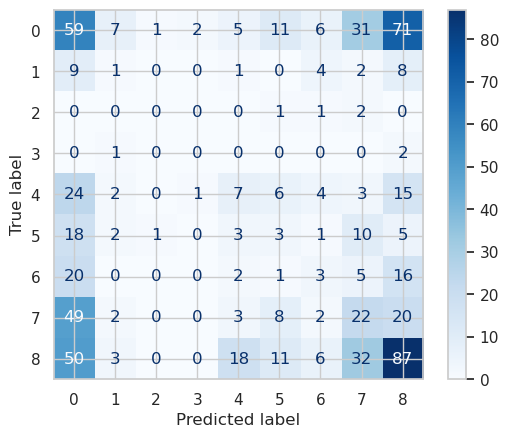

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch  # adjust if your batch is structured differently
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure k-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics across folds
all_preds = []
all_labels = []
fold_accuracies = []

# Get all indices
dataset_size = len(kernel_classification_dataset)
indices = list(range(dataset_size))

print(f"Starting {k_folds}-fold cross validation on {dataset_size} samples")

# K-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create data samplers for train and test
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32, 
        sampler=train_sampler
    )
    test_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32,
        sampler=test_sampler
    )
    
    # Get the input dimension from the dataset
    input_dim = kernel_classification_dataset.data[0][1].shape[0]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model, loss function, and optimizer
    model = GPKernelShipClassificationNetwork(
        input_dim=input_dim, 
        num_classes=max(unique_group_ids) + 1
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    trainer = GPKernelShipClassificationTrainer(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    trainer.train(num_epochs=1000)  # Reduced epochs for quicker k-fold demo
    
    # Evaluate on the test set
    fold_preds = []
    fold_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            mmsi, X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            fold_preds.extend(preds)
            fold_labels.extend(y.cpu().numpy())
    
    # Calculate fold accuracy
    fold_accuracy = np.mean(np.array(fold_preds) == np.array(fold_labels))
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
    
    # Add to overall results
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

# Calculate and display overall metrics
print("\n==== Cross-Validation Results ====")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Get unique classes that are actually present in the predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))

# Create class labels only for classes present in the data
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Generate and plot the aggregate confusion matrix with proper class labels
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(14, 12))



Starting 5-fold cross validation on 3453 samples

Fold 1/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


Fold 1 Accuracy: 0.2127

Fold 2/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


Fold 2 Accuracy: 0.3184

Fold 3/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


Fold 3 Accuracy: 0.3068

Fold 4/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s]


Fold 4 Accuracy: 0.2594

Fold 5/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [01:27<00:00, 11.49it/s]

Fold 5 Accuracy: 0.3014

==== Cross-Validation Results ====
Mean Accuracy: 0.2798 ± 0.0390


<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

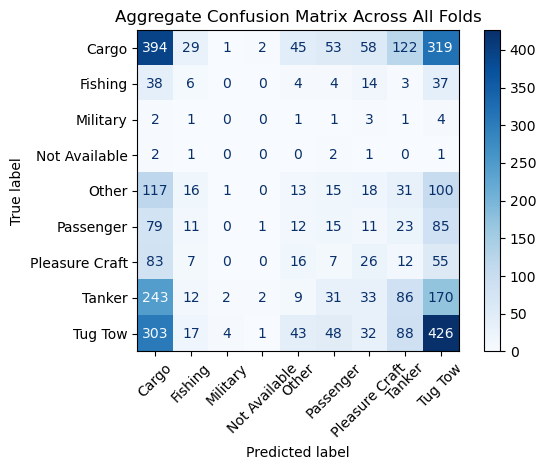


Classification Report:
                precision    recall  f1-score   support

         Cargo       0.31      0.39      0.35      1023
       Fishing       0.06      0.06      0.06       106
      Military       0.00      0.00      0.00        13
 Not Available       0.00      0.00      0.00         7
         Other       0.09      0.04      0.06       311
     Passenger       0.09      0.06      0.07       237
Pleasure Craft       0.13      0.13      0.13       206
        Tanker       0.23      0.15      0.18       588
       Tug Tow       0.36      0.44      0.39       962

      accuracy                           0.28      3453
     macro avg       0.14      0.14      0.14      3453
  weighted avg       0.26      0.28      0.26      3453


Class Distribution in Dataset:
Cargo: 1023 samples
Fishing: 106 samples
Military: 13 samples
Not Available: 7 samples
Other: 311 samples
Passenger: 237 samples
Pleasure Craft: 206 samples
Tanker: 588 samples
Tug Tow: 962 samples


In [16]:
import seaborn as sns 

sns.reset_orig() 
# Create the confusion matrix with class names that match the matrix dimensions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues', xticks_rotation=45)  # Rotate labels for better readability
plt.title('Aggregate Confusion Matrix Across All Folds')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Generate classification report with descriptive class names
print("\nClassification Report:")
target_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]
print(classification_report(all_labels, all_preds, labels=unique_present_classes, target_names=target_names))

# Print class distribution
print("\nClass Distribution in Dataset:")
class_counts = {}
for label in all_labels:
    class_name = id_to_vessel_group.get(label, f"Unknown ({label})")
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} samples")